参考：https://www.salesanalytics.co.jp/datascience/datascience087/


ARMA系モデルは全て、SARIMAモデルの特別な形として記述できる

- ARモデル：SARIMA( p,0,0 )( 0,0,0 )[0]
- MAモデル：SARIMA( 0,0,q )( 0,0,0 )[0]
- ARMAモデル：SARIMA( p,0,q )( 0,0,0 )[0]
- ARIMAモデル：SARIMA( p,d,q )( 0,0,0 )[0]
- SARIMAモデル：SARIMA( p,d,q )( P,D,Q )[m]
- SARIMAXモデル：SARIMAX( p,d,q )( P,D,Q )[m]

In [1]:
# ライブラリーの読み込み
import numpy as np
import pandas as pd
import pmdarima as pm
from pmdarima import utils
from pmdarima import arima
from pmdarima import model_selection
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from matplotlib import pyplot as plt
# グラフのスタイルとサイズ
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 9]

In [2]:
# データセットの読み込み
url='https://www.salesanalytics.co.jp/591h' #データセットのあるURL
df=pd.read_csv(url,                         #読み込むデータのURL
            index_col='Month',           #変数「Month」をインデックスに設定
            parse_dates=True)            #インデックスを日付型に設定
df.head() #確認

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


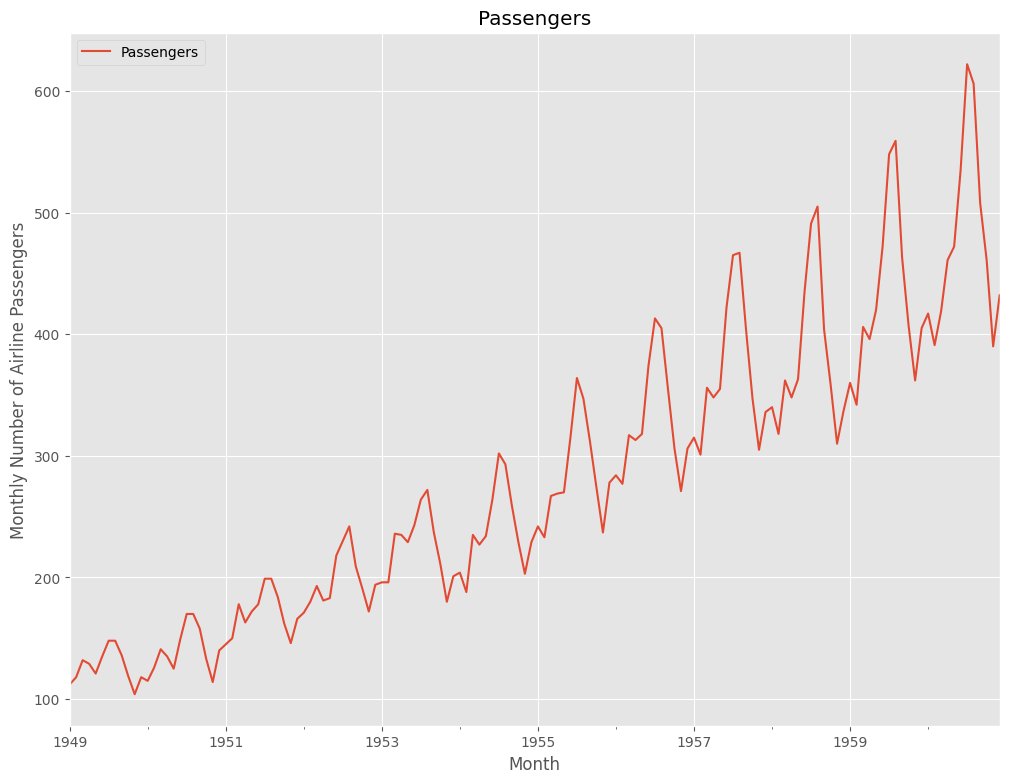

In [4]:
# プロット
df.plot()
plt.title('Passengers')                            #グラフタイトル
plt.ylabel('Monthly Number of Airline Passengers') #タテ軸のラベル
plt.xlabel('Month')                                #ヨコ軸のラベル
plt.show()

In [5]:
# 学習データとテストデータ（直近12ヶ月間）に分割
df_train, df_test = model_selection.train_test_split(df, test_size=12)

評価指標は以下の通り

■ 二乗平均平方根誤差（RMSE、Root Mean Squared Error）

■ 平均絶対誤差（MAE、Mean Absolute Error）

■ 平均絶対パーセント誤差（MAPE、Mean absolute percentage error）

### 原系列のままモデリング

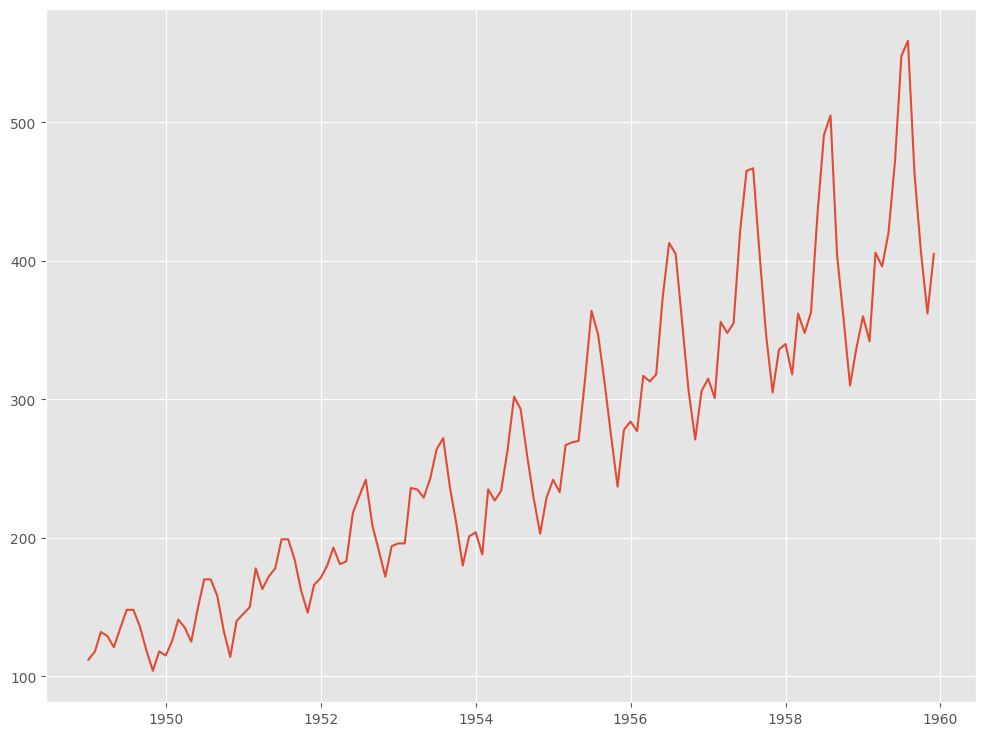

In [7]:
# 系列のプロット
plt.plot(df_train)

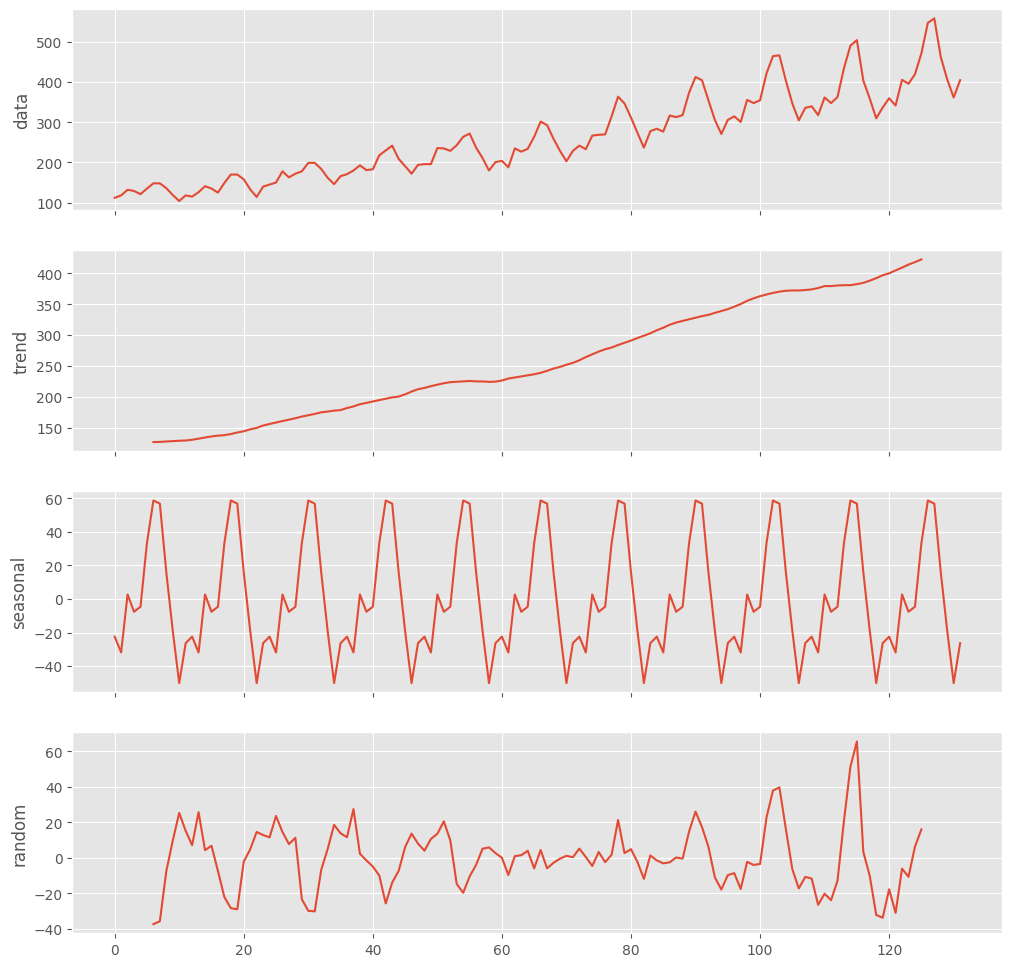

In [9]:
# 成分分解（tread・seasonal・random）
data = df_train.Passengers.values
utils.decomposed_plot(arima.decompose(data,'additive',m=12),
                        figure_kwargs = {'figsize': (12, 12)} )

In [10]:
# 階差の次数の検討
print('d =', arima.ndiffs(df))      #d
print('D =',arima.nsdiffs(df,m=12)) #D

d = 1
D = 1


/Users/tomokazu/miniforge3/envs/py310/lib/python3.10/site-packages/pmdarima/utils/visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


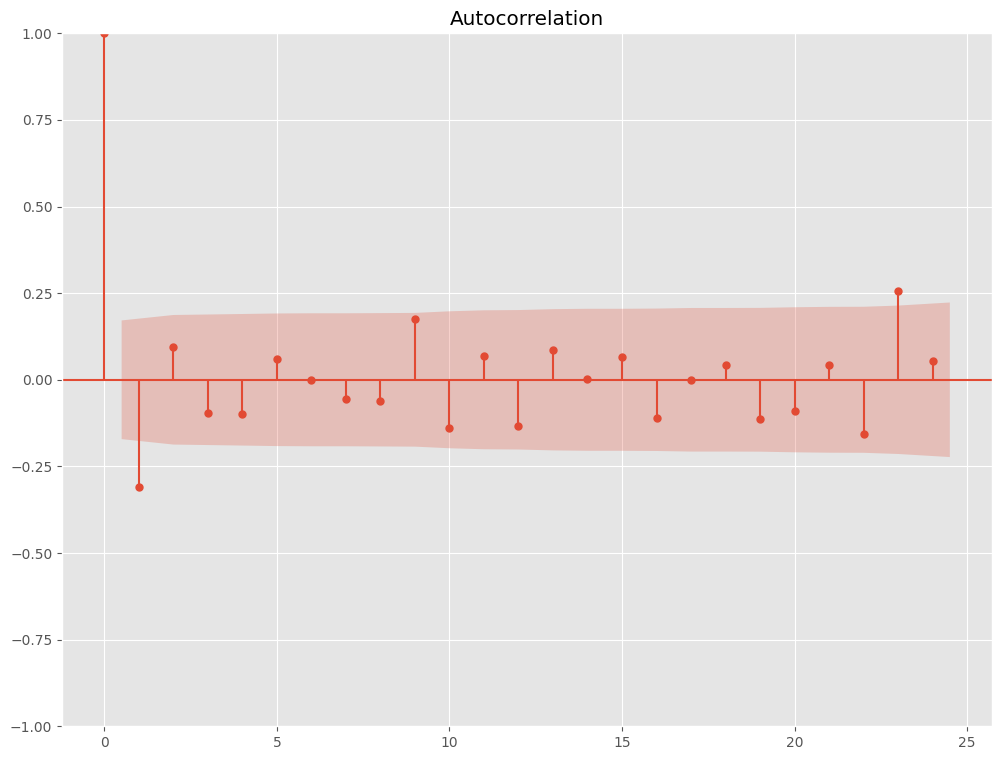

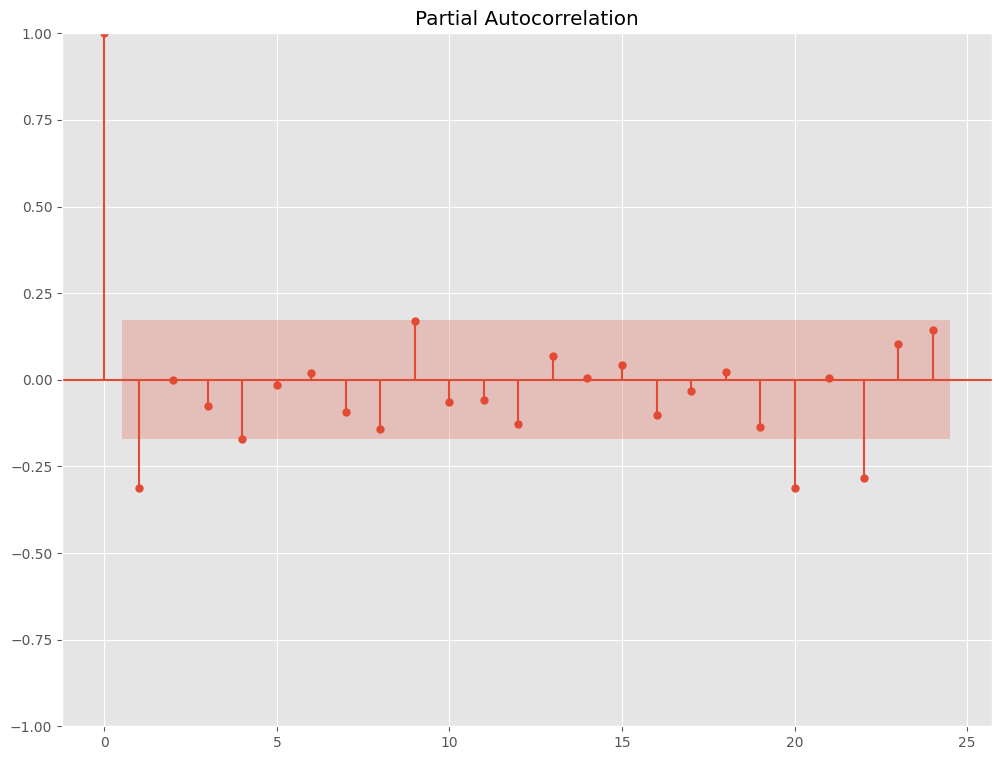

In [11]:
# コレログラム（自己相関と偏自己相関）
data = df.diff(1).diff(12).dropna()
utils.plot_acf(data, alpha=.05, lags=24)
utils.plot_pacf(data, alpha=.05, lags=24)

手動モデリング

In [12]:
# 原系列を学習データとする
train = df_train
# 学習
sarima_model = SARIMAX(train, order=(1, 1, 1), 
                        seasonal_order=(0, 1, 0,12))
sarima_fit = sarima_model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.39063D+00    |proj g|=  7.28451D-03

At iterate    5    f=  3.39006D+00    |proj g|=  6.33344D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     12      1     0     0   3.531D-07   3.390D+00
  F =   3.3900429508862624     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/tomokazu/miniforge3/envs/py310/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/tomokazu/miniforge3/envs/py310/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


In [13]:
# 予測
##学習データの期間の予測値
train_pred = sarima_fit.predict()
##テストデータの期間の予測値
test_pred = sarima_fit.forecast(len(df_test))
##予測区間
test_pred_ci = sarima_fit.get_forecast(len(df_test)).conf_int() 
# テストデータで精度検証
print('RMSE:')
print(np.sqrt(mean_squared_error(df_test, test_pred)))
print('MAE:')
print(mean_absolute_error(df_test, test_pred)) 
print('MAPE:')
print(mean_absolute_percentage_error(df_test, test_pred))

RMSE:
24.80943817656322
MAE:
19.56146862012108
MAPE:
0.04415712370191153


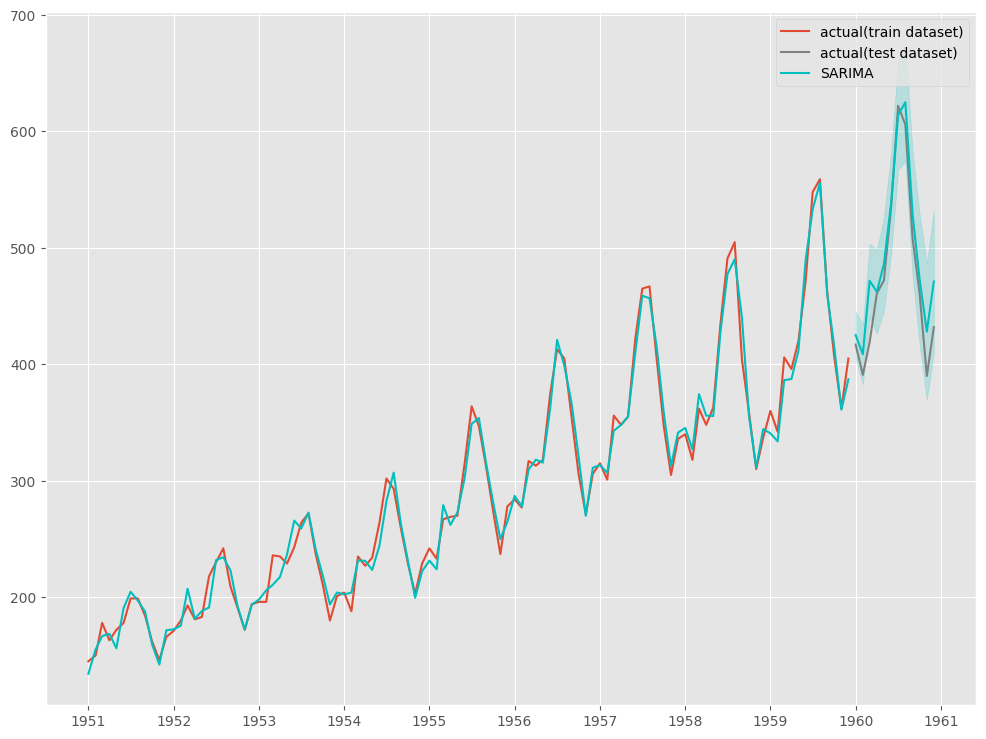

In [14]:
# グラフ化
fig, ax = plt.subplots()
ax.plot(df_train[24:].index, df_train[24:].values, label="actual(train dataset)")
ax.plot(df_test.index, df_test.values, label="actual(test dataset)", color="gray")
ax.plot(df_train[24:].index, train_pred[24:].values, color="c")
ax.plot(df_test.index, test_pred.values, label="SARIMA", color="c") 
ax.fill_between(
    df_test.index,
    test_pred_ci.iloc[:, 0],
    test_pred_ci.iloc[:, 1],
    color='c',
    alpha=.2)
ax.legend()

自動モデリング

In [15]:
# モデル構築（Auto ARIMA）
arima_model = pm.auto_arima(train, 
                            seasonal=True,
                            m=12,
                            trace=True,
                            n_jobs=-1,
                            maxiter=10)

/Users/tomokazu/miniforge3/envs/py310/lib/python3.10/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=911.913, Time=0.43 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1022.234, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=906.865, Time=0.17 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=963.556, Time=0.11 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1192.711, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=907.180, Time=0.02 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=908.723, Time=0.27 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=909.369, Time=0.15 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=907.124, Time=0.12 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=911.772, Time=0.46 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1021.870, Time=0.12 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=906.478, Time=0.15 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=906.075, Time=0.04 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=906.717, Time=0.09 sec
 ARIMA(2,0,0)(1,1,1)[12] inter

In [16]:
# 予測
##学習データの期間の予測値
train_pred = arima_model.predict_in_sample()
##テストデータの期間の予測値
test_pred, test_pred_ci = arima_model.predict(
    n_periods=df_test.shape[0], 
    return_conf_int=True
)
# テストデータで精度検証
print('RMSE:')
print(np.sqrt(mean_squared_error(df_test, test_pred)))
print('MAE:')
print(mean_absolute_error(df_test, test_pred)) 
print('MAPE:')
print(mean_absolute_percentage_error(df_test, test_pred))

RMSE:
18.536468695501895
MAE:
14.898208209798137
MAPE:
0.03097561514550175


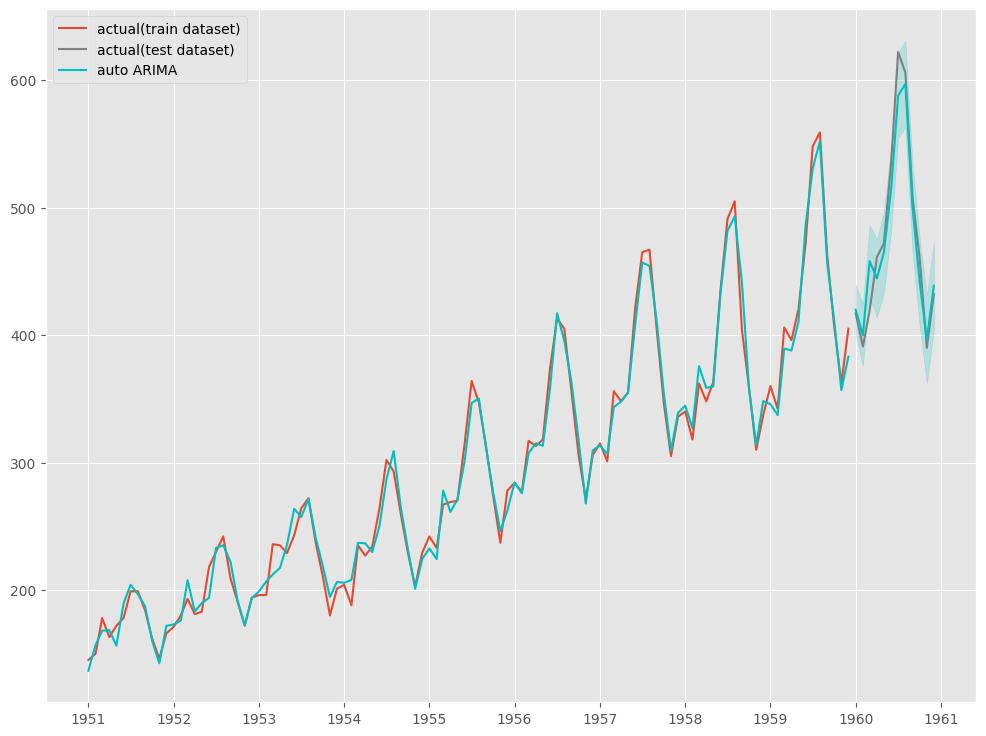

In [17]:
# グラフ化
fig, ax = plt.subplots()
ax.plot(df_train[24:].index, df_train[24:].values, label="actual(train dataset)")
ax.plot(df_test.index, df_test.values, label="actual(test dataset)", color="gray")
ax.plot(df_train[24:].index, train_pred[24:], color="c")
ax.plot(df_test.index, test_pred, label="auto ARIMA", color="c") 
ax.fill_between(
    df_test.index,
    test_pred_ci[:, 0],
    test_pred_ci[:, 1],
    color='c',
    alpha=.2)
ax.legend()

ハイブリッドモデリング（階差の次数のみ指定）

In [18]:
# モデル構築（Auto ARIMA）
arima_model = pm.auto_arima(train, 
                            seasonal=True,
                            m=12,
                            d=1,
                            D=1,
                            trace=True,
                            n_jobs=-1,
                            maxiter=10)

/Users/tomokazu/miniforge3/envs/py310/lib/python3.10/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=903.866, Time=0.30 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=905.065, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=900.823, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=901.721, Time=0.08 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=899.902, Time=0.02 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=901.052, Time=0.08 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=900.758, Time=0.14 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=901.337, Time=0.02 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=900.971, Time=0.02 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=900.685, Time=0.02 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=902.976, Time=0.04 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=901.457, Time=0.06 sec

Best model:  ARIMA(1,1,0)(0,1,0)[12]          
Total fit time: 0.861 seconds


In [19]:
# 予測
##学習データの期間の予測値
train_pred = arima_model.predict_in_sample()
##テストデータの期間の予測値
test_pred, test_pred_ci = arima_model.predict(
    n_periods=df_test.shape[0], 
    return_conf_int=True
)
# テストデータで精度検証
print('RMSE:')
print(np.sqrt(mean_squared_error(df_test, test_pred)))
print('MAE:')
print(mean_absolute_error(df_test, test_pred)) 
print('MAPE:')
print(mean_absolute_percentage_error(df_test, test_pred))


RMSE:
23.93167315445987
MAE:
18.527652948064404
MAPE:
0.04182388621703967


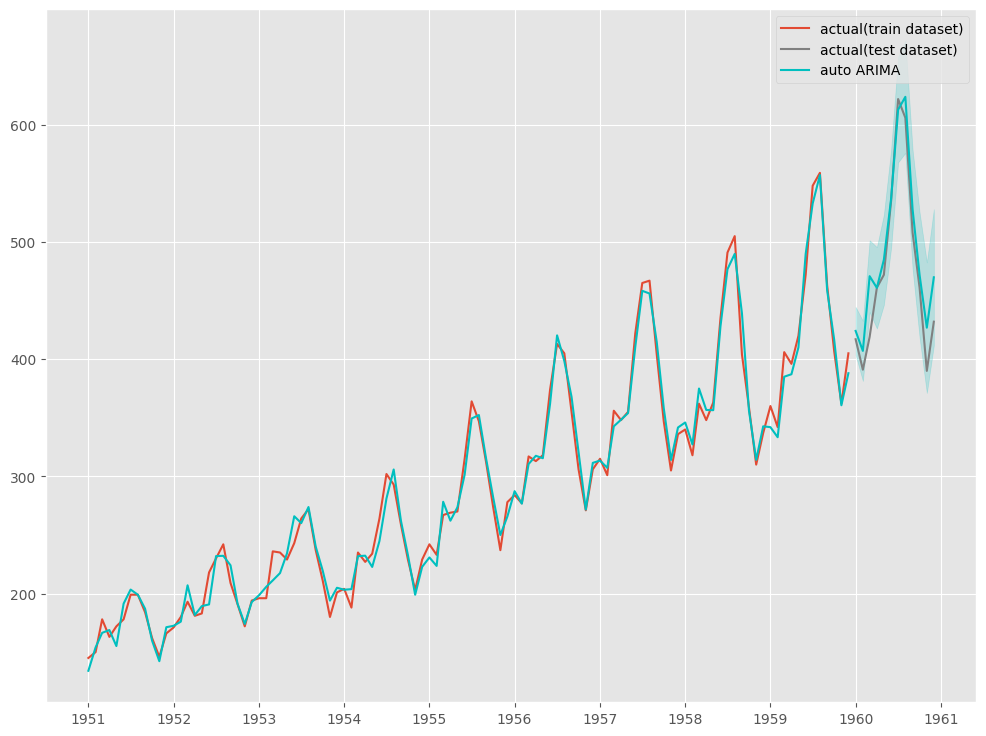

In [20]:
# グラフ化
fig, ax = plt.subplots()
ax.plot(df_train[24:].index, df_train[24:].values, label="actual(train dataset)")
ax.plot(df_test.index, df_test.values, label="actual(test dataset)", color="gray")
ax.plot(df_train[24:].index, train_pred[24:], color="c")
ax.plot(df_test.index, test_pred, label="auto ARIMA", color="c") 
ax.fill_between(
    df_test.index,
    test_pred_ci[:, 0],
    test_pred_ci[:, 1],
    color='c',
    alpha=.2)
ax.legend()
